# Parareal coupling FDTDs of different resolution

In [1]:
using PyPlot
using IterativeSolvers
using Interpolations

### Define Finite Difference scheme
**Problem setup:**

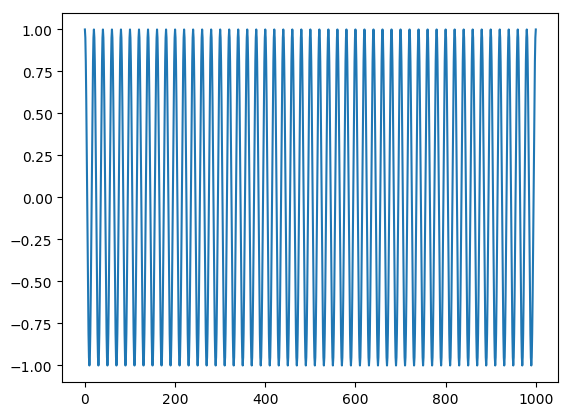

20.0

In [56]:
L = 200.0;
dX = 0.2;
X = collect(0:dX:L);
N = size(X,1);
k = pi/2;
u = exp.(im*k*(X));
ut = -im*k*u;
plot(u)
(2*pi/k)/dX

**Finite difference with velocity verlet update, periodic boundary condition**

In [3]:
function fdtd_wave(u0,ut0,dx,t_final)

    c = 1.0;
    dt = dx/1.0;    
    N = size(u0,1);
    u = complex(zeros(N));
    ut= complex(zeros(N));
    preu=complex(zeros(N));
    
    u[:] =u0;
    ut[:]=ut0;
    time = collect(dt:dt:t_final-dt);  # time array
    
    B = spdiagm((ones(N-1),-2*ones(N),ones(N-1)), (-1,0,1))/dx^2;
    B[1,N] = 1.0/dx^2;
    B[N,1] = 1.0/dx^2;
    
    wfd(y,yt) = y + yt*dt + 0.5*dt^2*c^2*B*y;
    
    for t = 1:Int(floor(t_final/dt))  
        preu[:]=u;
        u = wfd(u,ut);
        ut= ut+0.5*dt*c^2*(B*preu+B*u);
    end
    
    return (u,ut)

end

fdtd_wave (generic function with 1 method)

**test fdtd scheme**

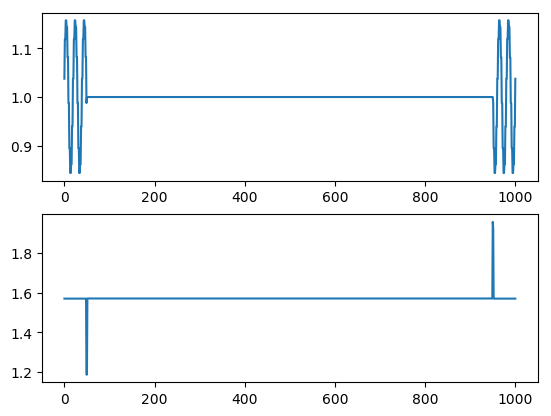

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000041D9ACC0>

In [57]:
uX,utX=fdtd_wave(u,ut,dX,10);
figure()
subplot(2,1,1)
plot(abs.(uX))
subplot(2,1,2)
plot(abs.(utX))

**test fdtd scheme with finer grid**

In [38]:
### interpolate u
function splineinterp(a,m)
    N=size(a,1);
    periodica=[a[end-2:end-1]; a; a[2:3]];
    itp_u  = interpolate(periodica,BSpline(Cubic(Line())), OnGrid());
    return itp_u[collect(3:1/m:N+2)];   
end

function fourierinterp(a,m)
    N=size(a,1);
    aff = fft(a);
    return ifft([aff[1:Int(floor(N/2))];complex(zeros((m-1)*(N-1)));aff[Int(floor(N/2))+1:end]])*((N-1)*m+1)/N;
end

fourierinterp (generic function with 1 method)

In [39]:
function downsamp(a,m)
    N=size(a,1);
    periodica=[a[end-3:end-1]; a; a[2:4]];
    itp_u = interpolate(periodica,BSpline(Constant()), OnGrid()); 
    return itp_u[collect(4:m:N+3)]; 
end

function fouriersamp(a,m)
    N=size(a,1);
    aff = fft(a);
    st=Int(floor(N/(2*m)))
    en=N-Int(floor(N/(2*m)))
    return ifft([aff[1:st];aff[en:end]])*((N-1)/m+1)/(N);
end

fouriersamp (generic function with 1 method)

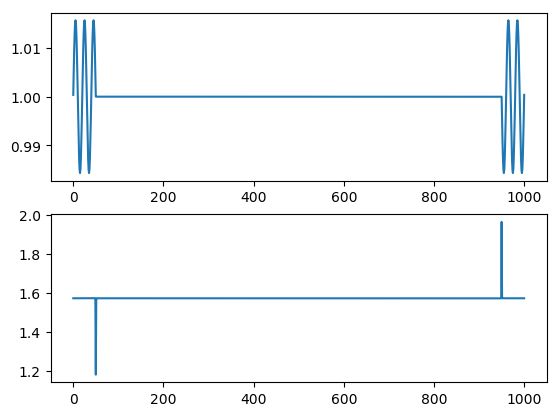

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000042478EB8>

In [58]:
m=10;
dx=dX/m;
x = collect(0:dx:L);

u4ff =  exp.(im*k*x);
#ut4f = zeros(size(x,1));#-im*k*u4f;
u4f = splineinterp(u,m);
ut4f = splineinterp(ut,m);

ub,utb=fdtd_wave(u4f,ut4f,dx,10);

ux  = downsamp(ub,m)
utx  = downsamp(utb,m)           

figure()
subplot(2,1,1)
plot(abs.(ux))
subplot(2,1,2)
plot(abs.(utx))

In [59]:
sum(abs.(fouriersamp(u4f,m).^2))-sum(abs.(u).^2)

-0.028342730774284064

In [60]:
mean(abs.(fouriersamp(fourierinterp(ub,m),m)-fourierinterp(fouriersamp(ub,m),m)))

5.598753763166348e-5

### Define parareal scheme
**use above fdtd subroutine to do parareal coupling of coarse and fine spatial grid size**

In [66]:
function wave1dparareal(u0,ut0,dX,pimax)
    t_final = 10;
    dT = 0.2;
    time = collect(0:dT:t_final);
    Nt = size(time,1);
    Nx = size(u0,1);
    
    u  = complex(zeros(Nx,Nt));
    ut = complex(zeros(Nx,Nt));
    
    u[:,1]  = u0[:];
    ut[:,1] = ut0[:];
    
    m = 10;
    dx = dX/m;
    
    # initial parareal guess
    for i=2:Nt
        u[:,i],ut[:,i]=fdtd_wave(u[:,i-1],ut[:,i-1],dX,dT);
    end
    
    # parareal iteration
    finesol = complex(zeros(Nx,Nt));
    finesolt = complex(zeros(Nx,Nt));
    coarsesol= complex(zeros(Nx,Nt));
    coarsesolt= complex(zeros(Nx,Nt));
    
    thetap = complex(eye(Nx,Nx));
    thetapt = complex(eye(Nx,Nx));
    g_ft=complex(zeros(Nx));
    gt_ft=complex(zeros(Nx));
    cfupdate=complex(zeros(Nx,Nt));
    cftupdate=complex(zeros(Nx,Nt));
    
    for pri=1:pimax
        # PARALLEL COMPUTATION
        for i=2:Nt
            u4f = fourierinterp(u[:,i-1],m);            
            ut4f = fourierinterp(ut[:,i-1],m);
            
            u_fine,ut_fine = fdtd_wave(u4f,ut4f,dx,dT);
            
            finesol[:,i]  = fouriersamp(u_fine,m);         
            finesolt[:,i]  = fouriersamp(ut_fine,m);   
            
            coarsesol[:,i],coarsesolt[:,i] = fdtd_wave(u[:,i-1],ut[:,i-1],dX,dT); 
        end

        
        # SERIAL UPDATE
        for i=2:Nt
            us,uts=fdtd_wave(u[:,i-1],ut[:,i-1],dX,dT);
            
            #thetap = thetap+(conj(finesol[:,i])*coarsesol[:,i].'/sum(abs.(coarsesol[:,i]).^2)-thetap)/((pri-1)*Nt+i);
            #thetapt = thetapt+(conj(finesolt[:,i])*coarsesolt[:,i].'/sum(abs.(coarsesolt[:,i]).^2)-thetapt)/((pri-1)*Nt+i);
            #thetap = thetap+(0.5*conj(gradient(finesol[:,i],dX))*gradient(coarsesol[:,i],dX).'/sum(abs.(gradient(coarsesol[:,i],dX).^2))
            #                 +0.5*conj(finesolt[:,i])*coarsesolt[:,i].'/sum(abs.(coarsesolt[:,i]).^2)
            #                 -thetap)/((pri-1)*Nt+i);
            #u[:,i] = conj(thetap)*us+finesol[:,i]-conj(thetap)*coarsesol[:,i];
            #ut[:,i] = conj(thetapt)*uts+finesolt[:,i]-conj(thetapt)*coarsesolt[:,i];
            
            #g_ft =g_ft+(conj(fft(finesol[:,i])).*fft(coarsesol[:,i])/sum(abs.(fft(coarsesol[:,i])).^2)-g_ft)/((pri-1)*Nt+i-1);
            #gt_ft=gt_ft+(conj(fft(finesolt[:,i])).*fft(coarsesolt[:,i])/sum(abs.(fft(coarsesolt[:,i])).^2)-gt_ft)/((pri-1)*Nt+i-1);
            """
            ffine = fft(finesol[:,i]);
            ffinet= fft(finesolt[:,i]);
            fcoarse=fft(coarsesol[:,i]);
            fcoarset=fft(coarsesolt[:,i]);
            gamm=sum(abs.(ffine).^2.*abs.(fcoarse).^2)/sum(abs.(ffine).^2.*abs.(fcoarse).^4);
            gammt=sum(abs.(ffinet).^2.*abs.(fcoarset).^2)/sum(abs.(ffinet).^2.*abs.(fcoarset).^4);
            alpha=conj(ffine).*fcoarse*gamm;
            betaa=conj(ffinet).*fcoarset*gammt;
            g_ft =g_ft+(alpha-g_ft)/((pri-1)*Nt+i-1);
            gt_ft=g_ft+(betaa-gt_ft)/((pri-1)*Nt+i-1);
            """
            g_ft=1;
            gt_ft=1;
            
            cfupdate[:,i] = fft(finesol[:,i])-conj(g_ft).*fft(coarsesol[:,i]);
            cftupdate[:,i]= fft(finesolt[:,i])-conj(gt_ft).*fft(coarsesolt[:,i]);
            u[:,i] = ifft(conj(g_ft).*fft(us)+cfupdate[:,i]);
            ut[:,i]= ifft(conj(gt_ft).*fft(uts)+cftupdate[:,i]);
            
        end       
        
        #figure()
        #contourf(abs.(cfupdate))
        #colorbar()
        
    end    
    
    return (u,ut,cfupdate)
    
end

wave1dparareal (generic function with 1 method)

**compute initial parareal guess**

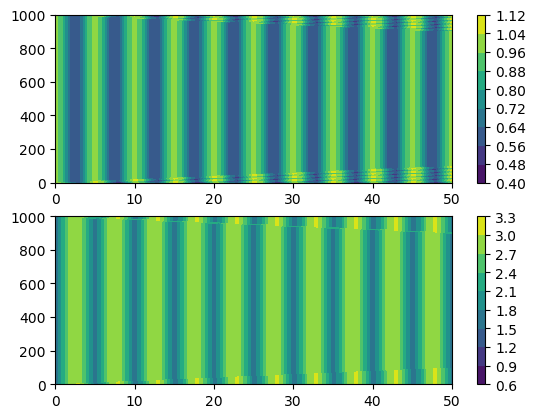

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000047BBB2B0>

In [61]:
dX=0.1;
u1,ut1=wave1dparareal(u,ut,dX,0);
subplot(2,1,1)
contourf(abs.(u1))
colorbar()
subplot(2,1,2)
contourf(abs.(ut1))
colorbar()

**compute full fine scale solution**

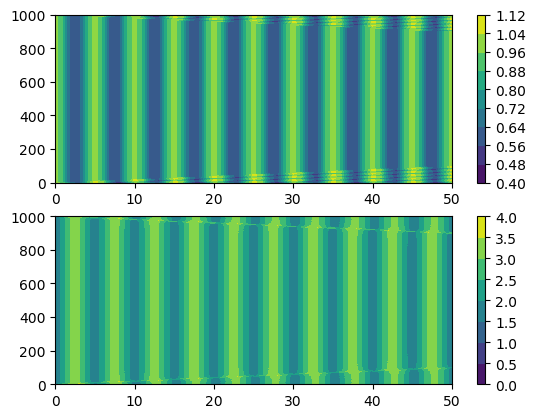

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000050639BA8>

In [62]:
m=10;
dx=dX/m;

u4f = fourierinterp(u,m);
ut4f = fourierinterp(ut,m);
x = collect(0:dx:L);
#u4f =  exp.(im*k*x);
#ut4f = -im*k*u4f;

ub,utb=wave1dparareal(u4f,ut4f,dx,0);

ubdown = complex(zeros(N,size(ub,2)))
utbdown = complex(zeros(N,size(utb,2)))

for i=1:size(ub,2)   
    ubdown[:,i]  = fouriersamp(ub[:,i],m)
    utbdown[:,i]  = fouriersamp(utb[:,i],m)  
end

subplot(2,1,1)
contourf(abs.(ubdown))
colorbar()
subplot(2,1,2)
contourf(abs.(utbdown))
colorbar()

**Tune parareal scheme**

In [ ]:
ug,ug2,upd=wave1dparareal(u,ut,dX,3);

In [ ]:
semilogy(maximum(abs.(ug-ubdown),1).')
#ylim([1e-3,2])

In [ ]:
semilogy(sum(abs.(upd),1).'*0.1)

In [ ]:
plot(sum(abs.(upd),1).'*0.1)

In [ ]:
contourf(fftshift(upd,1))
colorbar()

In [ ]:
plot(abs.(fftshift((upd[:,5])-fft(ubdown[:,5]))))

In [ ]:
p,pt=fdtd_wave(ug[:,4],ug2[:,4],dX,1);

In [ ]:
#plot(abs.(fftshift(fft(p))))
plot(abs.(((fftshift(fft(ubdown[:,5])))-fftshift(fft(p)))))

In [63]:
u2,ut2=wave1dparareal(u,ut,dX,2);
u3,ut3=wave1dparareal(u,ut,dX,10);
u4,ut4=wave1dparareal(u,ut,dX,30);

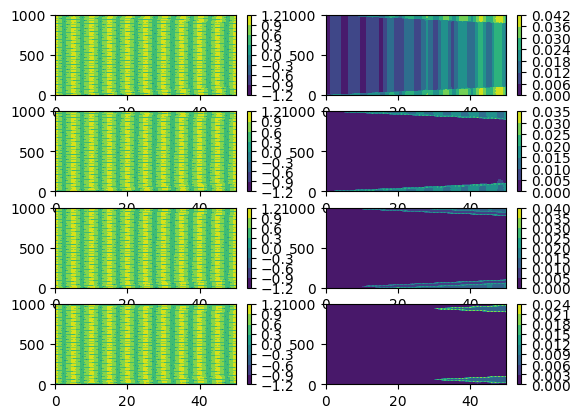

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000053A38F98>

In [64]:
figure()
subplot(4,2,1);contourf(real(u1));colorbar()
subplot(4,2,2);contourf(abs.(u1-ubdown));colorbar()
subplot(4,2,3);contourf(real(u2));colorbar()
subplot(4,2,4);contourf(abs.(u2-ubdown));colorbar()
subplot(4,2,5);contourf(real(u3));colorbar()
subplot(4,2,6);contourf(abs.(u3-ubdown));colorbar()
subplot(4,2,7);contourf(real(u4));colorbar()
subplot(4,2,8);contourf(abs.(u4-ubdown));colorbar()

In [67]:
u2s,ut2s=wave1dparareal(u,ut,dX,2);
u3s,ut3s=wave1dparareal(u,ut,dX,10);
u4s,ut4s=wave1dparareal(u,ut,dX,30);

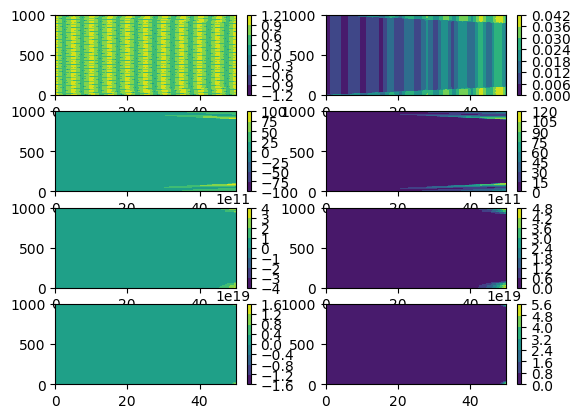

PyObject <matplotlib.colorbar.Colorbar object at 0x000000005886A860>

In [68]:
figure()
subplot(4,2,1);contourf(real(u1));colorbar()
subplot(4,2,2);contourf(abs.(u1-ubdown));colorbar()
subplot(4,2,3);contourf(real(u2s));colorbar()
subplot(4,2,4);contourf(abs.(u2s-ubdown));colorbar()
subplot(4,2,5);contourf(real(u3s));colorbar()
subplot(4,2,6);contourf(abs.(u3s-ubdown));colorbar()
subplot(4,2,7);contourf(real(u4s));colorbar()
subplot(4,2,8);contourf(abs.(u4s-ubdown));colorbar()

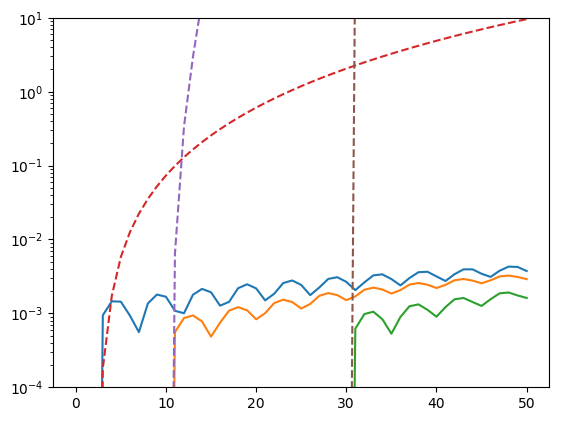

(0.0001, 10.0)

In [70]:
semilogy(mean(abs.(u2-ubdown),1).')
semilogy(mean(abs.(u3-ubdown),1).')
semilogy(mean(abs.(u4-ubdown),1).')

semilogy(mean(abs.(u2s-ubdown),1).',linestyle="--")
semilogy(mean(abs.(u3s-ubdown),1).',linestyle="--")
semilogy(mean(abs.(u4s-ubdown),1).',linestyle="--")

ylim([1e-4,10])

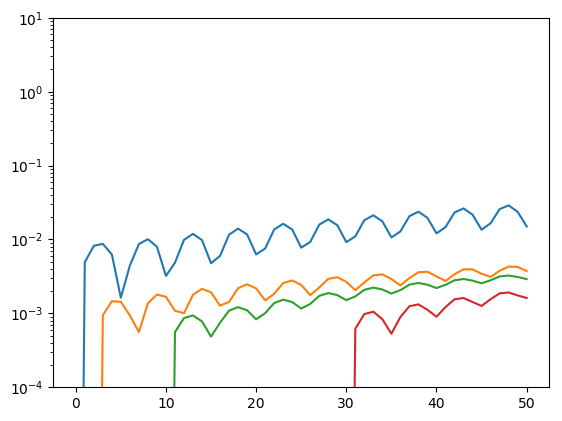

(0.0001, 10.0)

In [65]:
semilogy(mean(abs.(u1-ubdown),1).')
semilogy(mean(abs.(u2-ubdown),1).')
semilogy(mean(abs.(u3-ubdown),1).')
semilogy(mean(abs.(u4-ubdown),1).')

#semilogy(maximum(abs.(u2s-ubdown),1).',linestyle="--")
#semilogy(maximum(abs.(u3s-ubdown),1).',linestyle="--")
#semilogy(maximum(abs.(u4s-ubdown),1).',linestyle="--")
ylim([1e-4,10])

In [ ]:
plot((maximum(abs.(u3-ubdown),1)./maximum(abs.(u2-ubdown),1))')

In [ ]:
semilogy(maximum(abs.(u2-ubdown),1).')

In [ ]:
u50s,ut50s=wave1dparareal(u,ut,dX,50);

figure()
subplot(2,2,1);contourf(real(u50s));colorbar()
subplot(2,2,2);plot(log.(maximum(abs.(u50s-ubdown),1)).')

In [ ]:
uu1,utt1=wave1dparareal(u,ut,dX,1);
uu2,utt2=wave1dparareal(u,ut,dX,15);
uu3,utt3=wave1dparareal(u,ut,dX,30);
uu4,utt4=wave1dparareal(u,ut,dX,60);

In [ ]:
figure()
semilogy(maximum(abs.(u1-ubdown),1).')
semilogy(maximum(abs.(uu1-ubdown),1).')
semilogy(maximum(abs.(uu2-ubdown),1).')
semilogy(maximum(abs.(uu3-ubdown),1).')
semilogy(maximum(abs.(uu4-ubdown),1).')
ylim([1e-2,10])

In [ ]:
figure()
semilogy(maximum(abs.(ut1-utbdown),1).')
semilogy(maximum(abs.(utt1-utbdown),1).')
semilogy(maximum(abs.(utt2-utbdown),1).')
semilogy(maximum(abs.(utt3-utbdown),1).')
semilogy(maximum(abs.(utt4-utbdown),1).')
ylim([1e-1,10])